In [ ]:
!pip install nltk indic-transliteration


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 5.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



✅ Validation Accuracy: 0.7177

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74       890
           1       0.68      0.66      0.67      1128
           2       0.75      0.75      0.75       982

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000


🧮 Confusion Matrix:
 [[666 172  52]
 [184 746 198]
 [ 65 176 741]]


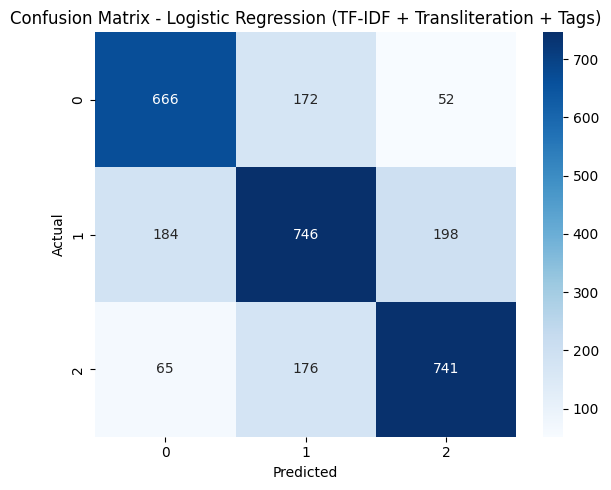

In [ ]:
import pandas as pd
import re
import nltk
from indic_transliteration.sanscript import transliterate, DEVANAGARI, ITRANS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# 1. Load dataset
train_df = pd.read_csv("/content/drive/MyDrive/FinalTrainingOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
val_df = pd.read_csv("/content/drive/MyDrive/ValidationOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)

# 2. Check if word is Hindi (Devanagari script)
def is_devanagari(word):
    return any('\u0900' <= ch <= '\u097F' for ch in word)

# 3. Preprocess text with transliteration and tagging
def preprocess_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", " mention ", text)
    text = re.sub(r"#\w+", " hashtag ", text)
    text = re.sub(r"[^\w\s\u0900-\u097F]", "", text)
    text = re.sub(r"\s+", " ", text)

    tokens = word_tokenize(text)
    processed = []
    for tok in tokens:
        if is_devanagari(tok):
            translit = transliterate(tok, DEVANAGARI, ITRANS)
            processed.append(f"[hin] {translit}")
        elif tok.isalpha():
            processed.append(f"[en] {tok.lower()}")
        else:
            processed.append(f"[oth] {tok}")
    return " ".join(processed)

train_df["text"] = train_df["text"].apply(preprocess_text)
val_df["text"] = val_df["text"].apply(preprocess_text)

# 4. Label encoding
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
val_df["label"] = le.transform(val_df["label"])

# 5. TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df["text"])
X_val = vectorizer.transform(val_df["text"])
y_train = train_df["label"]
y_val = val_df["label"]

# 6. Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# 7. Evaluation
y_pred = lr.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=[str(c) for c in le.classes_])
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", report)
print("\n🧮 Confusion Matrix:\n", conf_matrix)

# 8. Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (TF-IDF + Transliteration + Tags)")
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



✅ Validation Accuracy: 0.7493

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77       890
           1       0.72      0.70      0.71      1128
           2       0.77      0.78      0.78       982

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000


🧮 Confusion Matrix:
 [[691 147  52]
 [161 788 179]
 [ 60 153 769]]


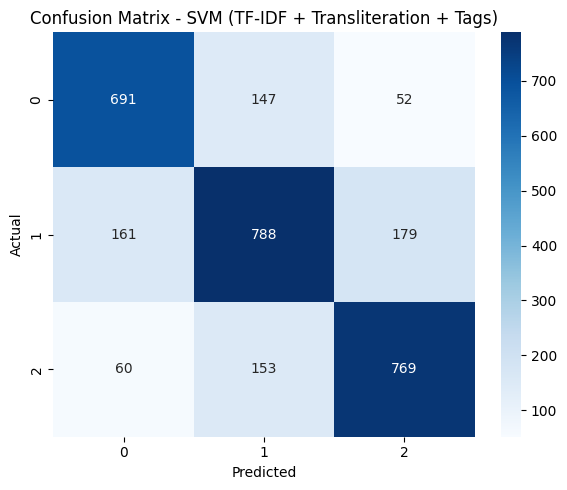

In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from indic_transliteration.sanscript import transliterate, DEVANAGARI, ITRANS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download tokenizer for NLTK
nltk.download('punkt')

# 1. Load dataset
train_df = pd.read_csv("/content/drive/MyDrive/FinalTrainingOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
val_df = pd.read_csv("/content/drive/MyDrive/ValidationOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)

# 2. Hindi word detection
def is_devanagari(word):
    return any('\u0900' <= ch <= '\u097F' for ch in word)

# 3. Preprocessing with transliteration and language tags
def preprocess_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", " mention ", text)
    text = re.sub(r"#\w+", " hashtag ", text)
    text = re.sub(r"[^\w\s\u0900-\u097F]", "", text)
    text = re.sub(r"\s+", " ", text)

    tokens = word_tokenize(text)
    processed = []
    for tok in tokens:
        if is_devanagari(tok):
            translit = transliterate(tok, DEVANAGARI, ITRANS)
            processed.append(f"[hin] {translit}")
        elif tok.isalpha():
            processed.append(f"[en] {tok.lower()}")
        else:
            processed.append(f"[oth] {tok}")
    return " ".join(processed)

# 4. Apply preprocessing
train_df["text"] = train_df["text"].apply(preprocess_text)
val_df["text"] = val_df["text"].apply(preprocess_text)

# 5. Label encoding
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
val_df["label"] = le.transform(val_df["label"])

# 6. TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df["text"])
X_val = vectorizer.transform(val_df["text"])
y_train = train_df["label"]
y_val = val_df["label"]

# 7. Train SVM
svm = LinearSVC(C=1.0)
svm.fit(X_train, y_train)

# 8. Evaluate
y_pred = svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=[str(c) for c in le.classes_])
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", report)
print("\n🧮 Confusion Matrix:\n", conf_matrix)

# 9. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (TF-IDF + Transliteration + Tags)")
plt.tight_layout()
plt.show()

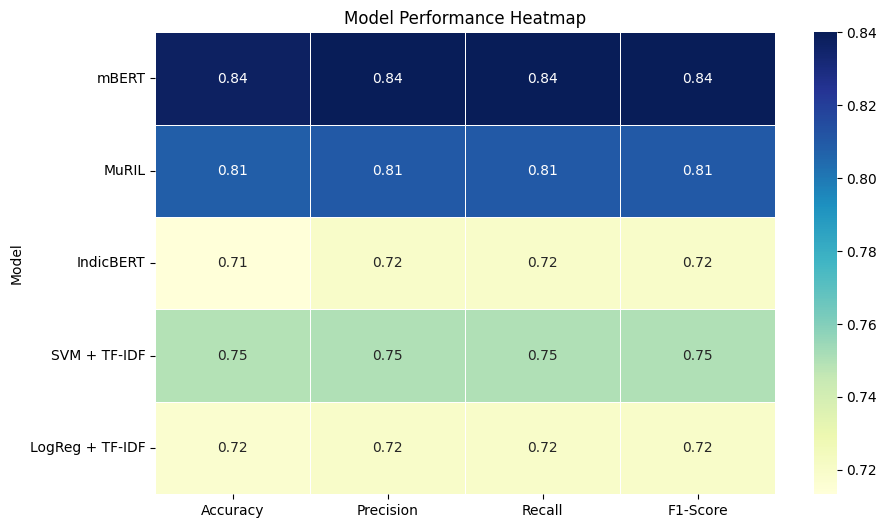

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data
data = {
    "Model": ["mBERT", "MuRIL", "IndicBERT", "SVM + TF-IDF", "LogReg + TF-IDF"],
    "Accuracy": [0.8373, 0.8083, 0.7133, 0.7493, 0.7177],
    "Precision": [0.84, 0.81, 0.72, 0.75, 0.72],
    "Recall": [0.84, 0.81, 0.72, 0.75, 0.72],
    "F1-Score": [0.84, 0.81, 0.72, 0.75, 0.72]
}

# Convert to DataFrame
df = pd.DataFrame(data)
df.set_index("Model", inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Model Performance Heatmap")
plt.show()
